# Predicting Customer Churn for a Telecom Company

We will build a predictive machine learning model to predict customer churn using the [Telco Customer Churn dataset](https://www.kaggle.com/datasets/blastchar/telco-customer-churn) from Kaggle. Here, Telco represents a fictional telecom company, and we're impersonating a Data Scientist at Telco, analyzing the data to uncover insights and building a churn prediction model that can predict if a customer is likely to churn or not.

## Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV

## Importing data and checking high-level characteristics

In [2]:
df = pd.read_csv('telco-customer-churn.csv')

print(df.head())
print(df.columns)
print(df.shape)

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

## Data Cleaning and Preparation

### Dropping unnecessary columns

In [3]:
# Drop 'customerID' column, since it has no usefulness in analysis or training a machine learning model
df = df.drop(['customerID'], axis=1)

print(df.columns)
print(df.shape)

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')
(7043, 20)


### Converting 'Churn' target variable to binary (0 or 1)

Let's convert the target variable 'Churn' to a numeric binary (1 and 0) representation, for compatibility with ML algorithms

In [4]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Validating a few records (first 10 records and last 3 columns, including 'Churn')
print(df.iloc[:10, -3:])

   MonthlyCharges TotalCharges  Churn
0           29.85        29.85      0
1           56.95       1889.5      0
2           53.85       108.15      1
3           42.30      1840.75      0
4           70.70       151.65      1
5           99.65        820.5      1
6           89.10       1949.4      0
7           29.75        301.9      0
8          104.80      3046.05      1
9           56.15      3487.95      0


### Checking for Missing Values

In [5]:
# Check for missing values
print(df.isna().sum())

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


There are no explicit missing values in the data.

### Checking datatypes of all columns and converting them where necessary

In [6]:
print(df.dtypes)

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                 int64
dtype: object


We see that 'TotalCharges' column is of 'object' type and needs to be converted to numeric

In [7]:
# Converting 'TotalCharges' column to numeric data type
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

We had to use errors='coerce' because there were conversion errors encountered due to blank strings " " in the 'TotalCharges' column. With errors='coerce', these blank strings would be converted to NaN values. Let's check this below.

### Check for and removing missing values after data type treatment

In [8]:
print(df.isna().sum())

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


We see that 'TotalCharges' has NaN values in 11 records. Let's check these records in detail

In [9]:
print(df[df['TotalCharges'].isna()])

      gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
488   Female              0     Yes        Yes       0           No   
753     Male              0      No        Yes       0          Yes   
936   Female              0     Yes        Yes       0          Yes   
1082    Male              0     Yes        Yes       0          Yes   
1340  Female              0     Yes        Yes       0           No   
3331    Male              0     Yes        Yes       0          Yes   
3826    Male              0     Yes        Yes       0          Yes   
4380  Female              0     Yes        Yes       0          Yes   
5218    Male              0     Yes        Yes       0          Yes   
6670  Female              0     Yes        Yes       0          Yes   
6754    Male              0      No        Yes       0          Yes   

         MultipleLines InternetService       OnlineSecurity  \
488   No phone service             DSL                  Yes   
753                 N

We see that 'Tenure' is 0 for all the above records. Since there are only 11 such records, let's drop them from consideration for further analysis.

In [10]:
print('Record count before filtering NaN values: ', len(df))

df = df.dropna(subset=['TotalCharges'])
df = df.reset_index(drop=True)

print('Record count after filtering NaN values: ', len(df))

Record count before filtering NaN values:  7043
Record count after filtering NaN values:  7032


## Exploratory Data Analysis

### Checking target class balance

In [11]:
print(df['Churn'].value_counts())

Churn
0    5163
1    1869
Name: count, dtype: int64


We see a significant imbalance between classes, with churned customers being far fewer than not churned customers overall. This is an important insight which will need to be considered later while training our machine learning model, to ensure greater reliability of predictions and f1-scores, and avoid bias toward the majority class.

While not implemented here, resampling techniques like oversampling the minority class (SMOTE) or undersampling the majority class can be used to address the imbalance itself and make the data more class-balanced. The former can be used with small to medium-sized datasets, while the latter should be used only on larger datasets

### Distribution of Customers by Monthly Charges, Total Charges and Tenure

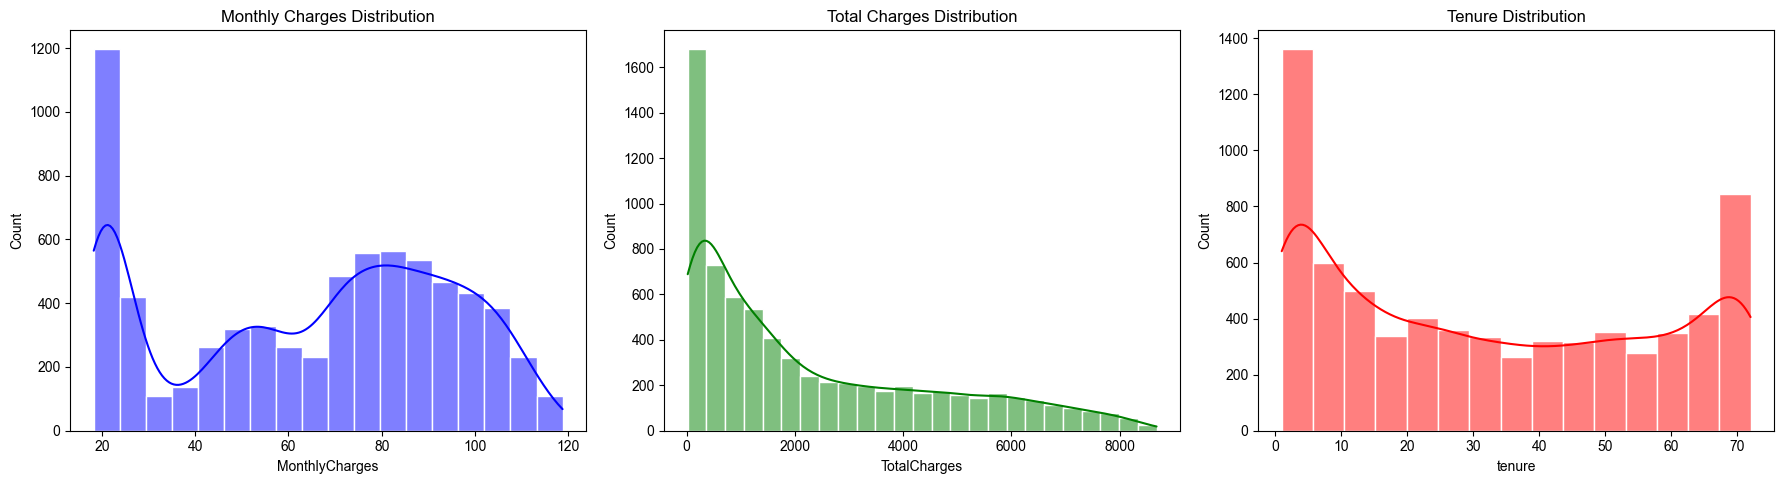

In [12]:
# Set up the figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.set(style="whitegrid")

# Plot MonthlyCharges distribution
sns.histplot(df['MonthlyCharges'], kde=True, ax=axes[0], color='blue')
axes[0].set_title('Monthly Charges Distribution')

# Plot TotalCharges distribution
sns.histplot(df['TotalCharges'], kde=True, ax=axes[1], color='green')
axes[1].set_title('Total Charges Distribution')

# Plot tenure distribution
sns.histplot(df['tenure'], kde=True, ax=axes[2], color='red')
axes[2].set_title('Tenure Distribution')

plt.tight_layout()
plt.show()

From the 'Monthly Charges Distribution' graph, we see a high concentration of customers taking subscriptions with low monthly charges (20-30). A relatively good concentration is also seen in the MonthlyCharges range of 70-90. This seems to suggest that customers are opting for either very low priced subscriptions or relatively high-priced subscriptions, but not that many are opting for the options in between (30-60).

In combination with the analysis of Total Charges and Tenure however, the higher-priced subscriptions (higher MonthlyCharges) don't seem indicative of a higher tenure/higher total charges.

Looking at the distribution of Tenure, we see an interesting pattern of high number of customers with either a small tenure (<5 months) or long tenure (>70 months).

### Tenure by Churn Status

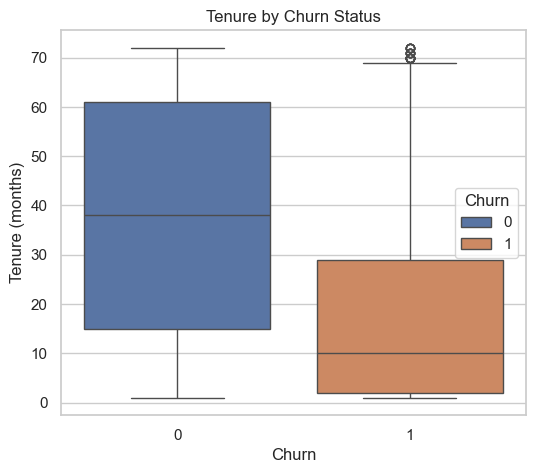

In [13]:
plt.figure(figsize=(6, 5))

# Boxplot of tenure grouped by churn
sns.boxplot(x='Churn', y='tenure', data=df, hue='Churn')

plt.title('Tenure by Churn Status')
plt.xlabel('Churn')
plt.ylabel('Tenure (months)')
plt.show()

We see very clearly that customers who churned had a significantly lower tenure on average. The median tenure for the non-churned customers is nearly 40 months, while the median tenure for the churned customers is only 10 months. This suggests that loyalty builds over time, and customers who churn generally tend to do so early in their relationship with the company. But if the company builds retention strategies targeted towards new customers, keeping them engaged for the first 1-2 years, then customers will be less likely to churn, improving overall customer retention.

### Churn by Contract Type

It's interesting to explore whether the type of contract (Month-to-month, One year, Two year) has a correlation with churn. Intuition would suggest that people with month-to-month contracts would be significantly more likely to churn than people with longer contracts. Let's analyze the churn, broken down by contract type, to test this hypothesis.

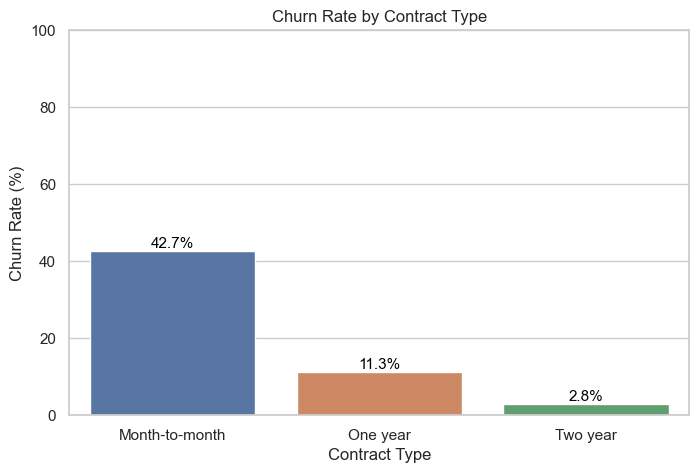

In [14]:
# Group by Contract and calculate Churn Rate
churn_by_contract = df.groupby('Contract')['Churn'].mean().reset_index()

# Convert churn rate to percentage value
churn_by_contract['ChurnRate'] = churn_by_contract['Churn'] * 100

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='Contract', y='ChurnRate', data=churn_by_contract, hue='Contract')

# Add data labels
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', fontsize=11, color='black')

# Y-axis as percent
ax.set_ylim(0, 100)
ax.set_ylabel('Churn Rate (%)')
ax.set_xlabel('Contract Type')
plt.title('Churn Rate by Contract Type')
plt.show()


This validates our hypothesis that Month-to-month contracts have significantly higher churn rates than One or Two-year contracts. This is likely due to customers with one or two year contracts having fewer opportunities to cancel and greater commitment before signing up due to higher upfront costs. The data clearly points to Contract Type being a strong predictor of churn.

### Monthly Charges (Subscription Rate) by Churn Status

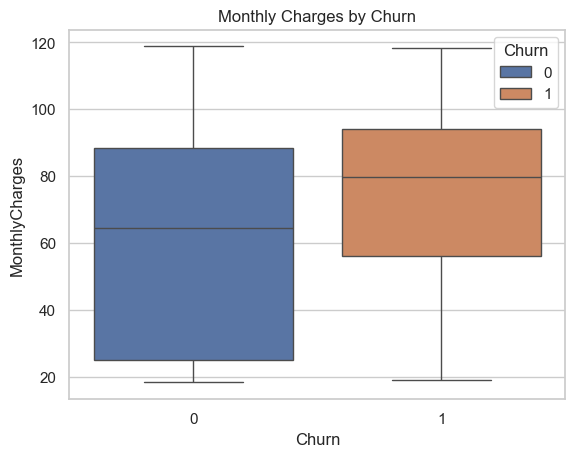

In [15]:
sns.boxplot(x='Churn', y='MonthlyCharges', data=df, hue='Churn')
plt.title('Monthly Charges by Churn')
plt.show()

Churned customers have noticeably higher median MonthlyCharges, at \$80, compared to \\$60-65 for non-churned customers. This suggests that higher monthly subscription rates may be a contributing factor to churn - possibly due to dissatisfaction with perceived value-for-money, or affordability reasons.

### Correlation Analysis (Heatmap) of Numerical Features with Churn

Let's get an overall picture of how tenure, MonthlyCharges and TotalCharges are correlated with Churn

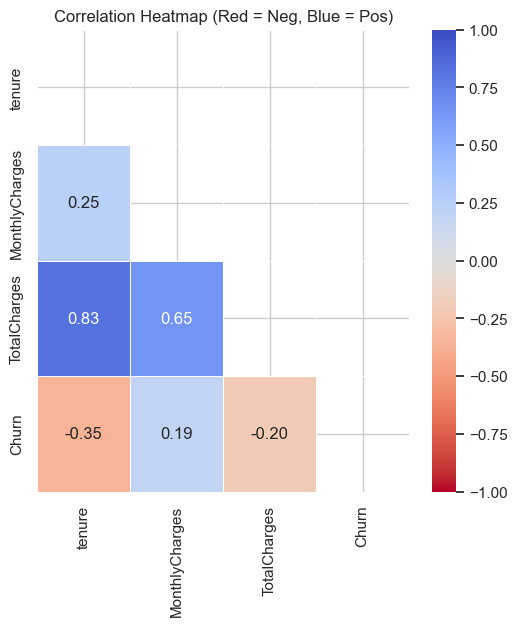

In [16]:
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']

# Compute the correlation matrix
corr = df[numerical_features].corr()

# Create mask to hide upper triangle + diagonal with all 1's
mask = np.triu(np.ones_like(corr, dtype=bool), k=0)

# Set up the matplotlib figure
plt.figure(figsize=(6, 6))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    cmap='coolwarm_r',     
    vmin=-1, vmax=1,       # force symmetric range for color contrast
    center=0,              # center the colormap at 0
    fmt=".2f",
    linewidths=0.5
)

plt.title('Correlation Heatmap (Red = Neg, Blue = Pos)')
plt.show()

We see a moderately negative correlation between tenure and Churn, which complements our finding from the previous Tenure by Churn boxplot. So we can generally expect that as tenure increases, the probability of Churn would decrease

## Model Selection

- The Telco customer churn dataset has a mix of many categorical features and a few numerical features
- Tree-based models like Random Forest can effectively handle mixed types natively, without requiring data scaling. Being an ensemble model, it is robust to noise, overfitting and can handle correlated features well (for example 'tenure' and 'TotalCharges', see Correlation Heatmap earlier). Since our focus is accuracy and reliability of churn prediction, we will use **Random Forest** as our main prediction model
- We will use **Logistic Regression** as a baseline model to compare Random Forest against, because it is fast, interpretable and simple. It sets a reasonable lower bound on model performance. In case a more complex model like Random Forest performs worse, it may hint to the possibility that overfitting is occurring, or hyperparameter tuning is necessary.

## Feature Engineering

Now, let's encode all the categorical features, for usability in our predictive models.

We will use Label Encoding on the features with only 2 categories and One-Hot Encoding on features having 3 or more categories.

### Identifying categorical features for Label Encoding and One-hot Encoding

In [17]:
label_encoding_cols = [
    'gender',                # Male/Female
    'Partner',               # Yes/No
    'Dependents',            # Yes/No
    'PhoneService',          # Yes/No
    'PaperlessBilling'       # Yes/No
]
# Feature 'SeniorCitizen' was already binary (1 and 0) in the original data, hence does not need encoding

one_hot_encoding_cols = [
    'InternetService',       # DSL, Fiber optic, No
    'Contract',              # Month-to-month, One year, Two year
    'PaymentMethod',         # 4 payment methods
    'MultipleLines',         # No phone service, Yes, No (and so on for the remaining columns)
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies'
]

### Encoding the categorical features

In [18]:
# Apply Label Encoding
for col in label_encoding_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Apply One-Hot Encoding (OHE)
df = pd.get_dummies(df, columns=one_hot_encoding_cols)

# Converting the boolean one-hot encoded features to binary (1 and 0), for uniform representation across the data
for col in df.columns:
    if df[col].dtype == bool:
        df[col] = df[col].astype(int)

print(df.head())
print('Columns:\n', df.columns)

   gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       0              0        1           0       1             0   
1       1              0        0           0      34             1   
2       1              0        0           0       2             1   
3       1              0        0           0      45             0   
4       0              0        0           0       2             1   

   PaperlessBilling  MonthlyCharges  TotalCharges  Churn  ...  \
0                 1           29.85         29.85      0  ...   
1                 0           56.95       1889.50      0  ...   
2                 1           53.85        108.15      1  ...   
3                 0           42.30       1840.75      0  ...   
4                 1           70.70        151.65      1  ...   

   DeviceProtection_Yes  TechSupport_No  TechSupport_No internet service  \
0                     0               1                                0   
1                     1       

### Checking datatypes after encoding categorical features (all should be numeric)

In [19]:
print(df.dtypes)

gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                               float64
Churn                                        int64
InternetService_DSL                          int64
InternetService_Fiber optic                  int64
InternetService_No                           int64
Contract_Month-to-month                      int64
Contract_One year                            int64
Contract_Two year                            int64
PaymentMethod_Bank transfer (automatic)      int64
PaymentMethod_Credit card (automatic)        int64
PaymentMethod_Electronic check               int64
PaymentMethod_Mailed check     

### Feature Scaling for Logistic Regression baseline model

While we do not require feature scaling for Random Forest as tree-based models are scale-invariant, we will need to scale the features for our baseline **Logistic Regression** model. We will scale the numeric features only.

In [20]:
df_scaled = df.copy()

numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

scaler = StandardScaler()
df_scaled[numeric_features] = scaler.fit_transform(df_scaled[numeric_features])

## Model Training and Evaluation

As mentioned earlier, we will use Logistic Regression as our baseline model and Random Forest as our main prediction model. We will use scaled data for Logistic Regression and unscaled data for Random Forest.

Let's start by first splitting the features and the target variable for both scaled and unscaled data

In [21]:
# Split the features and target variable
X_scaled = df_scaled.drop('Churn', axis=1)     # Scaled features for Logistic Regression
X = df.drop('Churn', axis=1)                   # Unscaled features for Random Forest

y = df['Churn']                                # Target variable

We will be using **Stratified K-Fold Cross Validation**, since there is class imbalance in the data as revealed in our EDA. We will use 5-fold cross validation, as it's generally considered ideal for balancing computational efficiency with reliable model evaluation. Let's configure it below.

In [22]:
cv = StratifiedKFold(n_splits=5)

### Logistic Regression (Baseline Model)

In [23]:
# Initializing the model
clf = LogisticRegression(class_weight='balanced', max_iter=10000, random_state=42)

# Cross-validation
scores = cross_val_score(clf, X_scaled, y, cv=cv, scoring='f1_macro')

print("F1 Macro scores:", scores)
print("Mean F1 Macro:", scores.mean())

F1 Macro scores: [0.7219623  0.7306795  0.71227187 0.71231554 0.71466987]
Mean F1 Macro: 0.7183798164363755


### Random Forest

Since this is our main predictive model, we will perform **hyperparameter tuning** to find an optimal set of hyperparameters. Two popular methods are RandomizedSearchCV and GridSearchCV. Let's use RandomizedSearchCV, which is more computationally efficient than GridSearchCV, since it only samples and tests a subset of all possible combinations of hyperparameters from a specified grid, while the latter exhaustively evaluates all combinations.

NOTE - The below cell might take 2-3 minutes to run

In [24]:
# Hyperparameter grid to test from
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Run RandomizedSearchCV
search = RandomizedSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    param_distributions=param_dist,
    scoring='f1_macro',
    cv=5,
    n_iter=30,       # sample and test 30 hyperparameter combinations from param_dist
    random_state=42,
    n_jobs=-1        # use all available CPU cores on machine, to speed up the process
)
search.fit(X, y)

# Get the most optimal combination of hyperparameters found by RandomizedSearchCV
best_params = search.best_params_
print("Best Params:", best_params)

Best Params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 15, 'bootstrap': True}


Now let's plug in these optimal hyperparameters into our Random Forest model.

In [25]:
# Initializing the model, plugging in the optimal hyperparameters found through RandomizedSearchCV
clf = RandomForestClassifier(class_weight='balanced', random_state=42, **best_params)

# Cross-validation
scores = cross_val_score(clf, X, y, cv=cv, scoring='f1_macro')

print("F1 Macro scores:", scores)
print("Mean F1 Macro:", scores.mean())

F1 Macro scores: [0.74836687 0.75018963 0.71588798 0.73487153 0.73287712]
Mean F1 Macro: 0.7364386250540258


Summarizing the f1 scores:
- Logistic Regression (baseline model) = 0.718
- Random Forest = 0.736

Thus, Random Forest after hyperparameter tuning shows better performance than our baseline Logistic Regression model.

## Conclusion

We have successfully analyzed the [Telco Customer Churn dataset](https://www.kaggle.com/datasets/blastchar/telco-customer-churn) from Kaggle, deriving key business insights from our Exploratory Data Analysis, and built a predictive machine learning model (Random Forest) to predict customer churn. We achieved an improvement over our baseline Logistic Regression model.